In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import joblib
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv("train_features.csv")
X = df.drop(columns=["label" , "en_label"]).values
y = df["en_label"].values

# No need to split - use full training set
X_train = X
y_train = y

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [14]:
models = {
    "SVM": SVC(kernel="rbf", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Neural Network": MLPClassifier(
        hidden_layer_sizes=(64, 32 , 16),  # Two hidden layers: 64 → 32 neurons
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42,
        early_stopping=True,          # Prevents overfitting
        validation_fraction=0.1       # Uses 10% of training data for validation
    )
}

trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    joblib.dump(model, f"{name.replace(' ', '_')}_model.pkl")

print("\n✅ All models trained and saved!")

Training SVM...
Training Random Forest...
Training Neural Network...

✅ All models trained and saved!


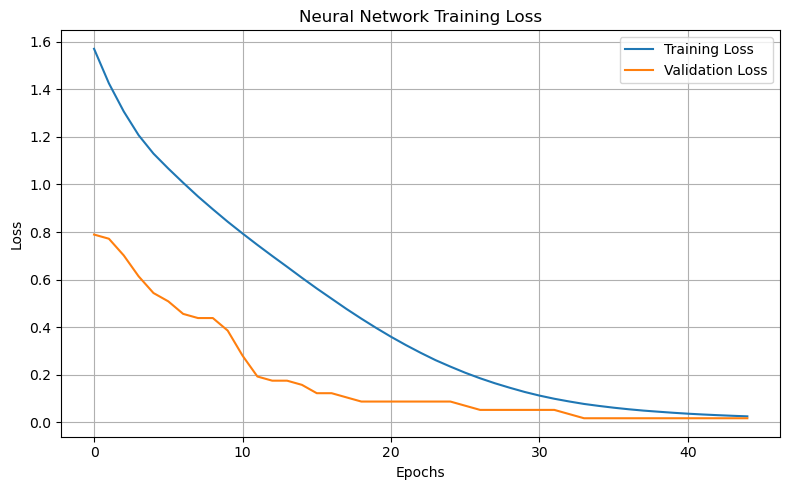

In [18]:
# Plot loss curve for Neural Network only
plt.figure(figsize=(8, 5))
nn_model = trained_models["Neural Network"]
plt.plot(nn_model.loss_curve_, label="Training Loss")
if hasattr(nn_model, 'validation_scores_'):
    # Convert validation scores to losses if available
    val_loss = [1 - score for score in nn_model.validation_scores_]
    plt.plot(val_loss, label="Validation Loss")
plt.title("Neural Network Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("img/nn_loss_curve.png")
plt.show()

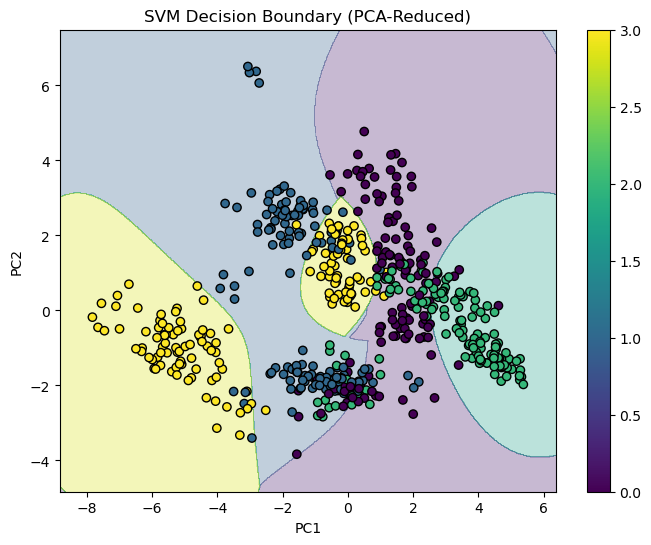

In [ ]:
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_svm = pca.fit_transform(X_train_scaled)
svm_2d = SVC(kernel="rbf", random_state=42).fit(X_svm, y_train)

# Create meshgrid
h = 0.02
x_min, x_max = X_svm[:, 0].min() - 1, X_svm[:, 0].max() + 1
y_min, y_max = X_svm[:, 1].min() - 1, X_svm[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="viridis")
scatter = plt.scatter(X_svm[:, 0], X_svm[:, 1], c=y_train, cmap="viridis", edgecolors='k')
plt.colorbar(scatter)
plt.title("SVM Decision Boundary (PCA-Reduced)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.savefig("img/svm_decision_boundary.png")
plt.show()

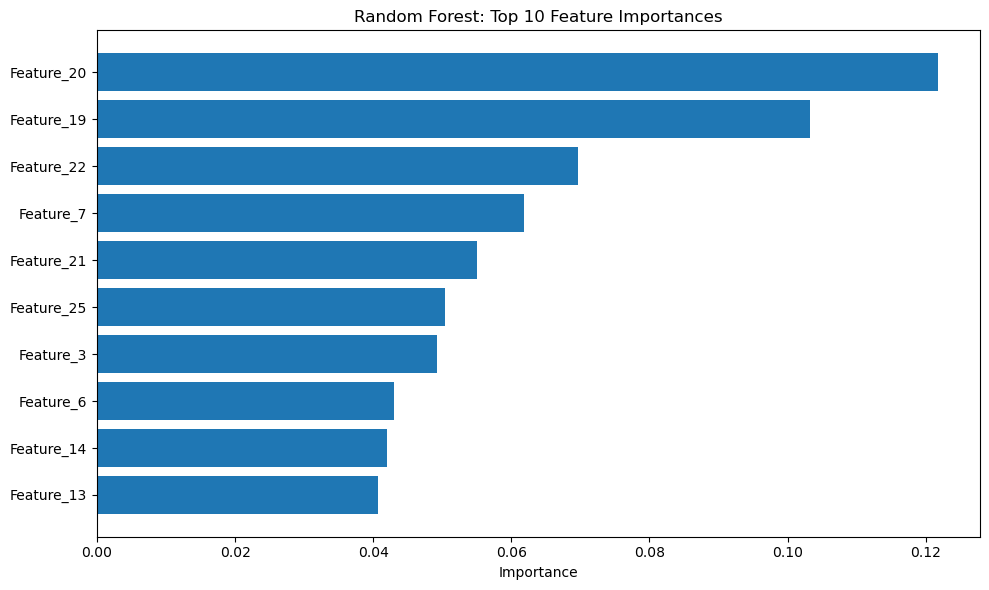

In [ ]:
rf_model = trained_models["Random Forest"]
importances = rf_model.feature_importances_
feature_names = [f"Feature_{i}" for i in range(len(importances))]  # Replace with actual names if available

# Plot top 10 features
indices = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.title("Random Forest: Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("img/rf_feature_importance.png")
plt.show()